In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, roc_auc_score, roc_curve, accuracy_score, confusion_matrix, classification_report

In [7]:
df = pd.read_csv('/Users/jiawenli/Desktop/MBAN_6110T/Class_10/heart_failure_clinical_records_dataset.csv')

In [8]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [9]:
# Quick inspection of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [10]:
import seaborn as sns

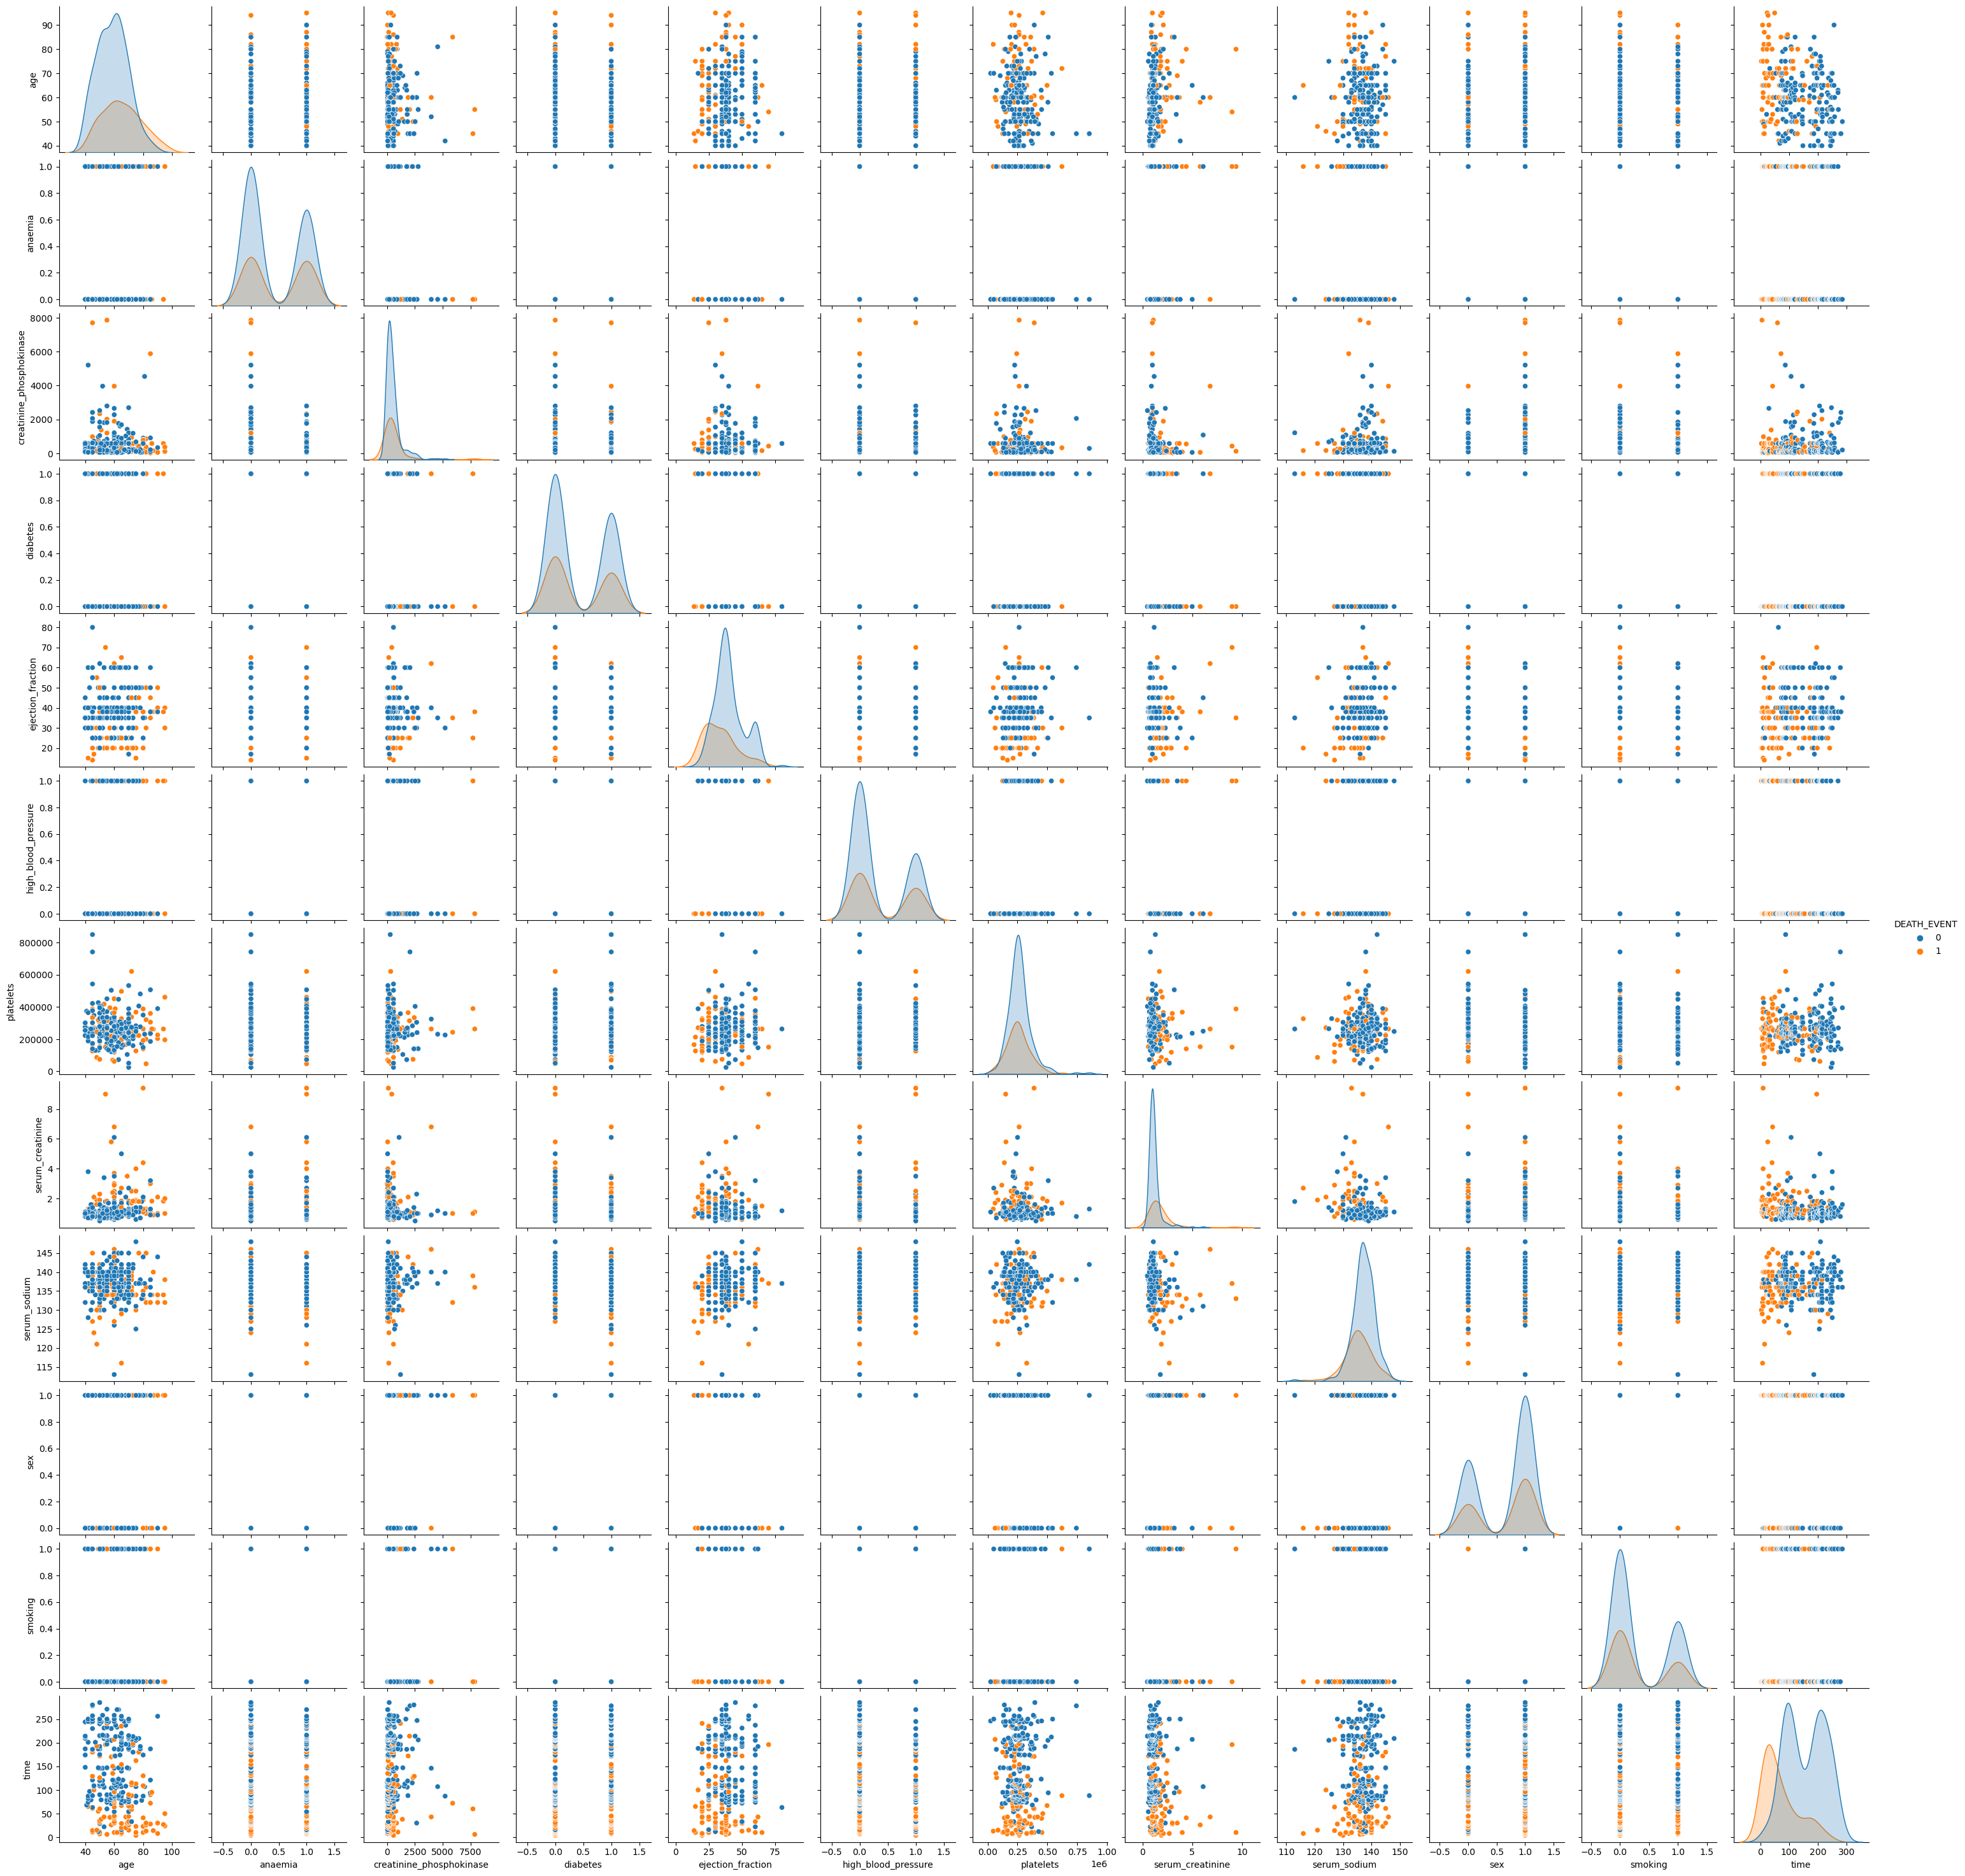

In [12]:
sns.pairplot(df, hue='DEATH_EVENT')

<Axes: xlabel='DEATH_EVENT', ylabel='age'>

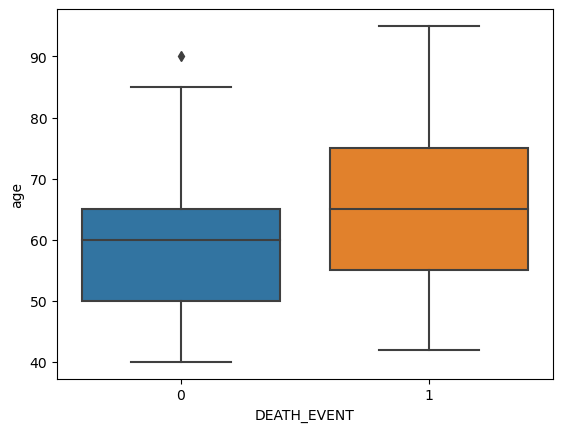

In [13]:
# Investigate 1 by 1
sns.boxplot(x='DEATH_EVENT', y='age', data=df)

<Axes: xlabel='DEATH_EVENT', ylabel='creatinine_phosphokinase'>

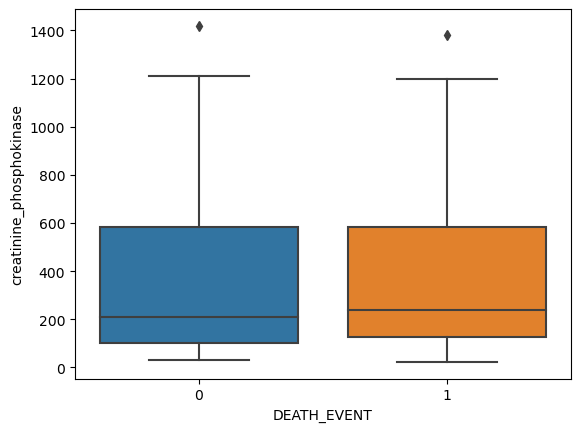

In [17]:
sns.boxplot(x='DEATH_EVENT', y='creatinine_phosphokinase', data=df[df['creatinine_phosphokinase']<=1500])


<Axes: xlabel='DEATH_EVENT', ylabel='ejection_fraction'>

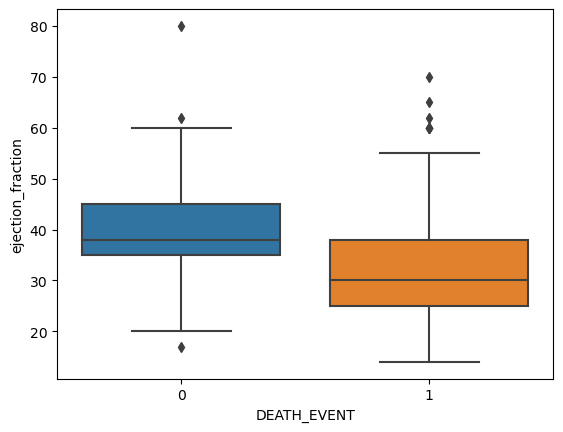

In [18]:
# Ejetion fraction (percentage of blood leaving the heart at each contraction)
sns.boxplot(x='DEATH_EVENT', y='ejection_fraction', data=df)

<Axes: xlabel='DEATH_EVENT', ylabel='creatinine_phosphokinase'>

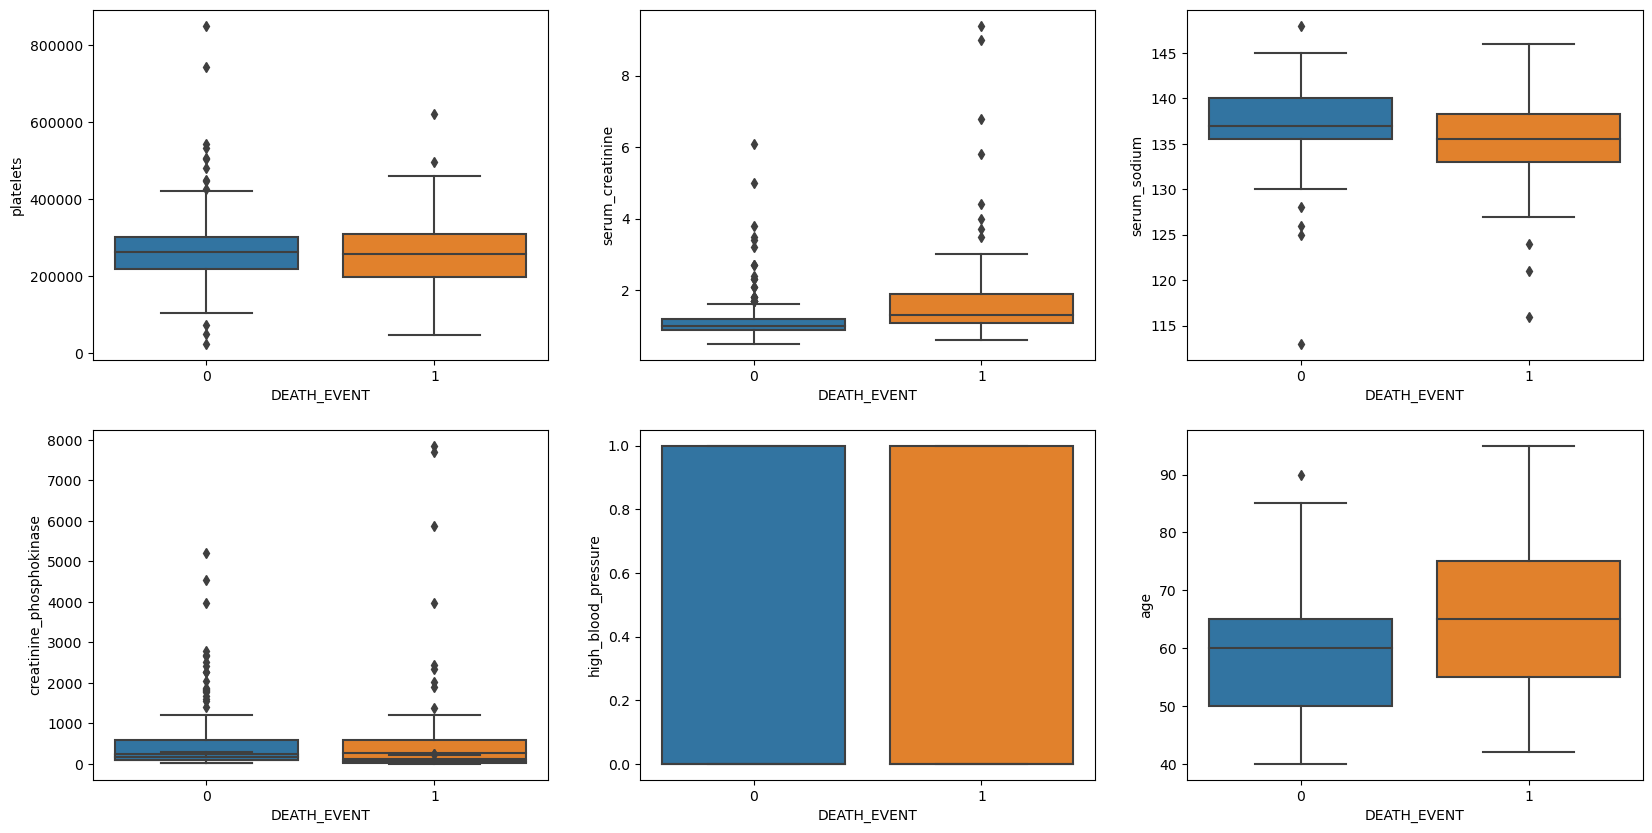

In [20]:
import matplotlib.pyplot as plt
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(20,10))
sns.boxplot(x='DEATH_EVENT', y='platelets', data=df, ax=ax1)
sns.boxplot(x='DEATH_EVENT', y='serum_creatinine', data=df, ax=ax2)
sns.boxplot(x='DEATH_EVENT', y='serum_sodium', data=df, ax=ax3)
sns.boxplot(x='DEATH_EVENT', y='time', data=df, ax=ax4)
sns.boxplot(x='DEATH_EVENT', y='high_blood_pressure', data=df, ax=ax5)
sns.boxplot(x='DEATH_EVENT', y='age', data=df, ax=ax6)
sns.boxplot(x='DEATH_EVENT', y='creatinine_phosphokinase', data=df, ax=ax4)

In [21]:
# initial hypothesis, age, serum_creatinine, ejection_fraction, serum_sodium, time, high_blood_pressure, creatinine_phosphokinase
# look at categorical variables

df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

In [22]:
df.groupby(['DEATH_EVENT','anaemia'])[[ 'diabetes', 'high_blood_pressure', 'sex', 'smoking']].count()

diabetes  high_blood_pressure  sex  smoking
DEATH_EVENT anaemia                                             
0           0             120                  120  120      120
            1              83                   83   83       83
1           0              50                   50   50       50
            1              46                   46   46       46

In [26]:
df_anaemia = df.groupby(['DEATH_EVENT','anaemia'])[['sex']].count().unstack()

In [27]:
df_anaemia['total'] = df_anaemia['sex'][0] + df_anaemia['sex'][1]

In [28]:
df_anaemia['percent_0'] = df_anaemia['sex'][0] + df_anaemia['sex'][1] / df_anaemia['total']

In [30]:
df_anaemia = df.groupby(['DEATH_EVENT','anaemia'])[['sex']].count().unstack()
df_anaemia['total'] = df_anaemia['sex'][0] + df_anaemia['sex'][1]
df_anaemia['percent_1'] = df_anaemia['sex'][0] / df_anaemia['total']
df_anaemia['percent_1'] = df_anaemia['sex'][1] / df_anaemia['total']
df_anaemia

sex     total percent_1
anaemia        0   1                
DEATH_EVENT                         
0            120  83   203  0.408867
1             50  46    96  0.479167

In [35]:
df_diabetes = df.groupby(['DEATH_EVENT','diabetes'])[['sex']].count().unstack()
df_diabetes['total'] = df_diabetes['sex'][0] + df_diabetes['sex'][1]
df_diabetes['percent_0'] = df_diabetes['sex'][0] / df_diabetes['total']
df_diabetes['percent_1'] = df_diabetes['sex'][1] / df_diabetes['total']
df_diabetes

sex     total percent_0 percent_1
diabetes       0   1                          
DEATH_EVENT                                   
0            118  85   203  0.581281  0.418719
1             56  40    96  0.583333  0.416667

In [34]:
df_sex = df.groupby(['DEATH_EVENT','sex'])[['smoking']].count().unstack()
df_sex.columns = df_sex.columns.droplevel()
df_sex['total'] = df_sex[0] + df_sex[1]
df_sex['percent_1'] = df_sex[1] / df_sex['total']
df_sex

sex,0,1,total,percent_1
DEATH_EVENT,,,,
0,71,132,203,0.650246
1,34,62,96,0.645833


In [37]:
df_smoking = df.groupby(['DEATH_EVENT','smoking'])[['sex']].count().unstack()
df_smoking['total'] = df_smoking['sex'][0] + df_smoking['sex'][1]
df_smoking['percent_0'] = df_smoking['sex'][0] / df_smoking['total']
df_smoking['percent_1'] = df_smoking['sex'][1] / df_smoking['total']
df_smoking

sex     total percent_0 percent_1
smoking        0   1                          
DEATH_EVENT                                   
0            137  66   203  0.674877  0.325123
1             66  30    96  0.687500  0.312500

In [38]:
# refined hypothesis age, serum_creatinine, serum_sodium, ejection_fraction, anaemia

log = LogisticRegression()
log.fit(df[['age', 'serum_creatinine', 'serum_sodium', 'ejection_fraction', 'anaemia']], df['DEATH_EVENT'])

LogisticRegression()

In [40]:
pred = log.predict(df[['age', 'serum_creatinine', 'serum_sodium', 'ejection_fraction', 'anaemia']])

In [41]:
print(accuracy_score(df['DEATH_EVENT'], pred))
print(f1_score(pred, df['DEATH_EVENT']))

0.7558528428093646
0.546583850931677


In [42]:
pd.DataFrame(log.coef_, columns=['age', 'serum_creatinine', 'serum_sodium', 'ejection_fraction', 'anaemia'])

,age,serum_creatinine,serum_sodium,ejection_fraction,anaemia
0,0.051142,0.621052,-0.050997,-0.066602,0.298362


In [45]:
pd.DataFrame(log.feature_names_in_, log.coef_.flatten())

,0
0.051142,age
0.621052,serum_creatinine
-0.050997,serum_sodium
-0.066602,ejection_fraction
0.298362,anaemia


In [46]:
x = df[['age', 'anaemia', 'ejection_fraction', 'high_blood_pressure', 'serum_creatinine', 'serum_sodium']]
y = df['DEATH_EVENT']

In [47]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1234)

In [48]:
from sklearn.svm import SVC

In [54]:
knn = KNeighborsClassifier()
log = LogisticRegression()
nb = GaussianNB()
svc = SVC(kernel='linear')

In [55]:
knn.fit(x_train, y_train)
log.fit(x_train, y_train)
nb.fit(x_train, y_train)
svc.fit(x_train, y_train)

SVC(kernel='linear')

In [56]:
knn_pred = knn.predict(x_test)
log_pred = log.predict(x_test)
nb_pred = nb.predict(x_test)
svc_pred = svc.predict(x_test)

In [57]:
print(f1_score(y_test, knn_pred))
print(f1_score(y_test, log_pred))
print(f1_score(y_test, nb_pred))
print(f1_score(y_test, svc_pred))

0.42424242424242425
0.6
0.4166666666666667
0.5714285714285714


In [59]:
# Narrow down modeling to SVC and Logistic Regression
# Finding the best parameters for SVC
param_svc = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

randomsearch_svc = RandomizedSearchCV(svc, param_svc, cv=10, scoring='f1', n_iter=15, random_state=1234)
randomsearch_svc.fit(x_train, y_train)

/Users/jiawenli/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=15. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=10, estimator=SVC(kernel='linear'), n_iter=15,
                   param_distributions={'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']},
                   random_state=1234, scoring='f1')

In [60]:
randomsearch_svc.best_params_

{'kernel': 'linear'}

In [61]:
log_pred_prob = log.predict_proba(x_test)

In [62]:
log_pred_prob

array([[0.86774117, 0.13225883],
       [0.80662151, 0.19337849],
       [0.74255348, 0.25744652],
       [0.79677647, 0.20322353],
       [0.47185531, 0.52814469],
       [0.47029164, 0.52970836],
       [0.70932025, 0.29067975],
       [0.8504059 , 0.1495941 ],
       [0.9832635 , 0.0167365 ],
       [0.82113433, 0.17886567],
       [0.75669579, 0.24330421],
       [0.97286609, 0.02713391],
       [0.63170614, 0.36829386],
       [0.42608937, 0.57391063],
       [0.63525883, 0.36474117],
       [0.942267  , 0.057733  ],
       [0.87374595, 0.12625405],
       [0.85125078, 0.14874922],
       [0.96966823, 0.03033177],
       [0.67231055, 0.32768945],
       [0.87019364, 0.12980636],
       [0.54541995, 0.45458005],
       [0.19226315, 0.80773685],
       [0.22222728, 0.77777272],
       [0.59084583, 0.40915417],
       [0.7938926 , 0.2061074 ],
       [0.62278785, 0.37721215],
       [0.76334095, 0.23665905],
       [0.76118693, 0.23881307],
       [0.8631043 , 0.1368957 ],
       [0.

In [63]:
fpr, tpr ,thresholds = roc_curve(y_test, log_pred_prob[:,1]) 

In [64]:
gmeans = np.sqrt(tpr*(1-fpr))

In [65]:
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[np.argmax(gmeans)], np.max(gmeans)))

Best Threshold=0.368294, G-Mean=0.798


In [66]:
y_pred_new = []
for i in log_pred_prob[:,1]:
    if i < thresholds[np.argmax(gmeans)]:
        y_pred_new.append(0)
    else:
        y_pred_new.append(1)

In [67]:
print(f1_score(y_pred_new,y_test))

0.7222222222222222
